# Modelo SARIMAX



In [57]:
import os
# os.environ["SM_FRAMEWORK"] = "tf.keras"
import pathlib
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# import seaborn as sns
import datetime as dt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Flatten, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
# from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

In [58]:
#Conexión de google drive con el repo
# from google.colab import drive
# drive.mount('/content/drive')
# ruta = os.path.join("/content/drive/MyDrive","MonografiaUdeA")
# os.chdir(ruta)
##==========================
abspath = pathlib.Path.cwd()
print(f"Directorio de trabajo: {abspath}")
###==========================

Directorio de trabajo: d:\Repos_\MonografiaUdeA


In [59]:
modelo_implementar = ['SARIMAX']

def parse(x):
    return dt.datetime.strptime(x, '%Y-%m-%d')
dataset = pd.read_csv(os.path.join(abspath,"datasets", "procesado", "3_dataset_filtrado.csv"), index_col=0, date_parser=parse)
df = dataset.copy()#.iloc[:,[0]].reset_index()
df = df[['precio_bolsa', 'precio_oferta']].reset_index()

In [60]:
df['fecha'] = pd.to_datetime(df['fecha'])
df.set_index('fecha', inplace=True)
df.head()

,precio_bolsa,precio_oferta
fecha,,
2010-01-01,120.501228,267.437633
2010-01-02,118.495340,277.153592
2010-01-03,121.160145,313.552755
2010-01-04,123.962937,303.519878
2010-01-05,120.666437,339.600449


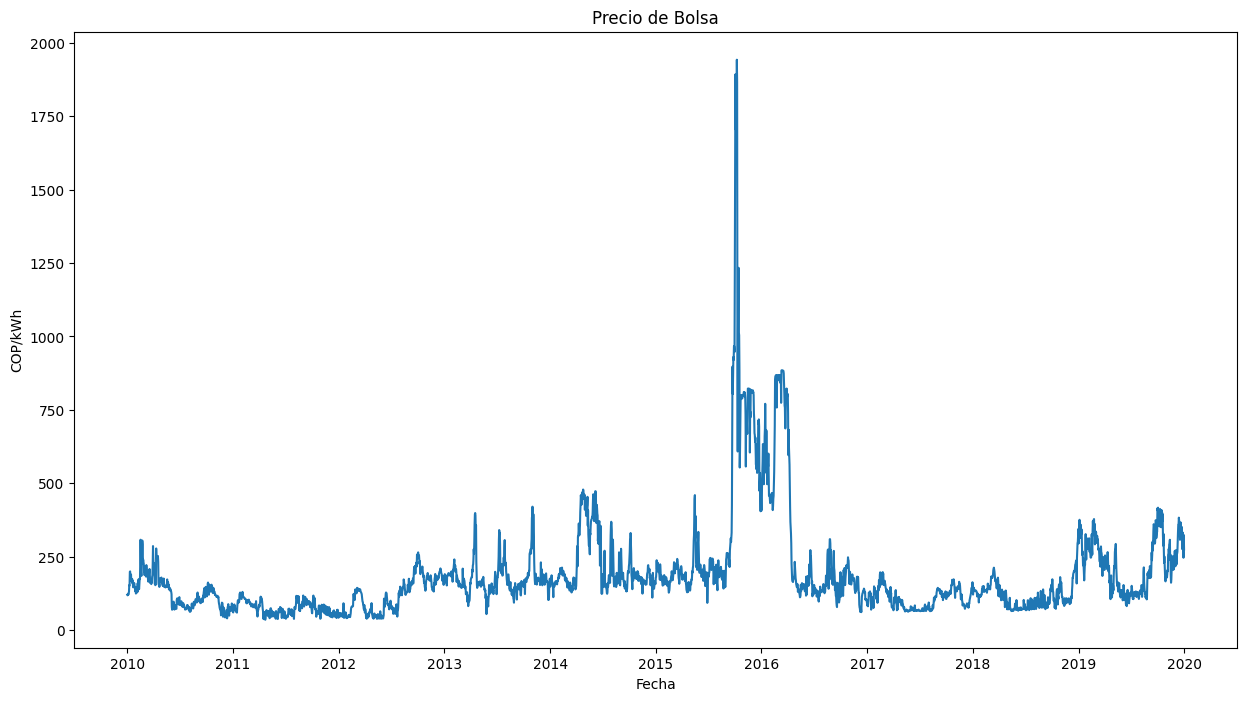

In [61]:
# Plot the time series
plt.figure(figsize = (15,8))
plt.plot(df['precio_bolsa'])
plt.title('Precio de Bolsa')
plt.xlabel('Fecha')
plt.ylabel('COP/kWh')
plt.show()

## Validación de estacionariedad

In [62]:
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(df['precio_bolsa'])
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -4.436130
p-value: 0.000256


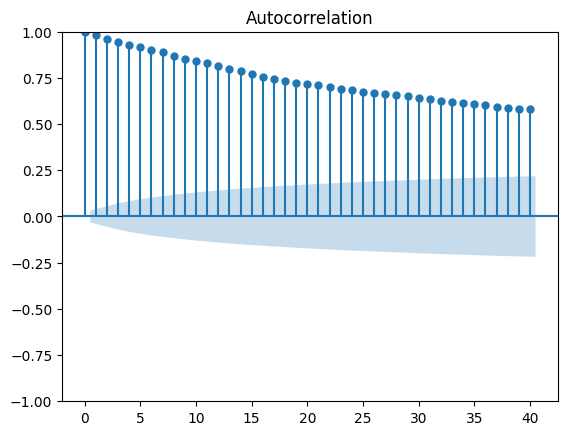

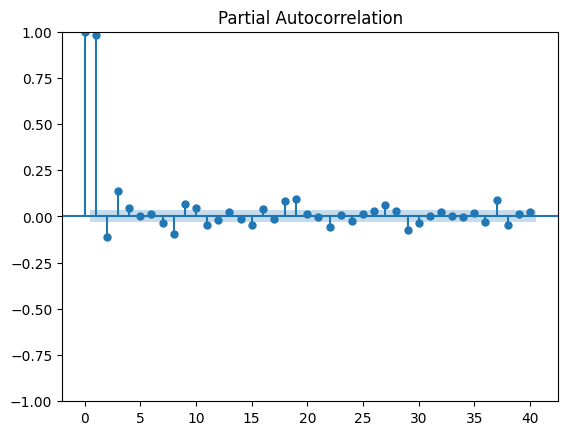

In [63]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['precio_bolsa'], lags=40)
plot_pacf(df['precio_bolsa'], lags=40)
plt.show()

Un valor p inferior a 0,05 indica estacionariedad y nuestros datos cumplen con este criterio, por lo que no es necesario realizar diferenciación.

In [64]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# model = ARIMA(df['precio_bolsa'], order=(1, 0, 1))
# model_fit = model.fit()

In [65]:
# forecast = model_fit.get_forecast(steps=30)

In [66]:
from sklearn.metrics import mean_squared_error

def sarimax_model (df, p, d , q , P , D , Q , s , train_porc = 0.8):
    train_size = int(len(df) * train_porc)+1
    train, test = df[0:train_size], df[train_size:len(df)]

    model_train = SARIMAX(train['precio_bolsa'], order=(p, d, q), seasonal_order=(P, D, Q, s))
    model_train_fit = model_train.fit()

    test_forecast = model_train_fit.get_forecast(steps=len(test))
    test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)
    mae = mean_absolute_error(test['precio_bolsa'], test_forecast_series)
    mse = mean_squared_error(test['precio_bolsa'], test_forecast_series)
    mape = mean_absolute_percentage_error(test['precio_bolsa'], test_forecast_series)
    rmse = mse**0.5

    return (mae, mse, rmse, mape, model_train_fit)

In [67]:
from itertools import product

p_values = [1]
d_values = [0]
q_values = [1]
P_values = [1]
D_values = [0]
Q_values = [1]
s_values = [12]
combinacion_parametros = list(product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values))

In [68]:
import warnings
warnings.filterwarnings("ignore")
def get_best_model(df, combinacion_parametros):
    best_score = float("inf")
    best_params = []
    for element in combinacion_parametros:
        p, d, q, P, D, Q, s = element
        mae, mse, rmse, mape, model = sarimax_model(df,p = p, d = d, q = q, P = P, D = D, Q = Q, s=s)
        print(element, mse)
        if mse < best_score:
            best_score, best_params = mse, element

    return mae, mse, rmse, mape, best_params, model

mae, mse, rmse, mape, best_params, SARIMAX_model = get_best_model(df, combinacion_parametros)

(1, 0, 0, 1, 0, 1, 12) 32694.20089779973


In [69]:
import pickle
with open(os.path.join(abspath,"models", "iterations",modelo_implementar[0], "model.pkl"),'wb') as f:
    pickle.dump(SARIMAX_model,f)

In [70]:
with open(os.path.join(abspath,"models", "iterations",modelo_implementar[0], "model.pkl"),'rb') as f:
    mp = pickle.load(f)

In [71]:
mp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         precio_bolsa   No. Observations:                 2922
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood              -14468.919
Date:                              Thu, 20 Jun 2024   AIC                          28945.838
Time:                                      15:24:41   BIC                          28969.758
Sample:                                  01-01-2010   HQIC                         28954.453
                                       - 12-31-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9929      0.001   1207.688      0.000       0.991       0.995
ar.S.L12       0.6755      0.122      5.519      0.000       0.436       0.915
ma.S.L12      -0.7126      0.118     -6.027      0.000      -0.944      -0.481
sigma2      1169.2878      4.354    268.547      0.000    1160.754    1177.822
===================================================================================
Ljung-Box (L1) (Q):                  48.87   Jarque-Bera (JB):           4092779.04
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              15.01   Skew:                            -4.90
Prob(H) (two-sided):                  0.00   Kurtosis:                       186.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [72]:
train_porc = 0.8
train_size = int(len(df) * train_porc)+1
train, test = df[0:train_size], df[train_size:len(df)]
y_pred = mp.get_forecast(steps=730).predicted_mean

In [73]:
# !pip install pydataxm
import pydataxm
from pydataxm.pydataxm import ReadDB
consult = ReadDB()

In [74]:
precio_bolsa = consult.request_data("PrecBolsNaci", "Sistema", dt.date(2018, 1, 1), dt.date(2018, 1, 31) )
hours = [f"Values_Hour{str(i).zfill(2)}" for i in range(1,25)]
precio_bolsa['precio_bolsa'] = precio_bolsa[hours].mean(axis=1)
precio_bolsa = precio_bolsa.groupby('Date')['precio_bolsa'].mean().reset_index()
precio_bolsa = precio_bolsa[ ['Date'] + ['precio_bolsa']]
precio_bolsa = precio_bolsa.rename(columns = {'Date': 'fecha'}).sort_values(by = 'fecha', ascending = True).reset_index(drop = True)
precio_bolsa['fecha'] = pd.to_datetime(precio_bolsa['fecha'])
precio_bolsa = precio_bolsa.set_index('fecha')
precio_bolsa.to_csv(os.path.join(abspath,"datasets", "procesado","precio_bolsa_ene_2020.csv"), index=True)

In [75]:
precio_bolsa_pronosticado = pd.DataFrame(pd.Series(y_pred))
precio_bolsa_pronosticado.columns = ['precio_bolsa_pronosticado']
df_final = pd.merge(precio_bolsa,precio_bolsa_pronosticado, how = 'left', left_index = True, right_index=True)
df_final.head()

,precio_bolsa,precio_bolsa_pronosticado
fecha,,
2018-01-01,121.032082,149.185093
2018-01-02,136.319515,147.711053
2018-01-03,135.042328,146.282619
2018-01-04,144.265848,145.001196
2018-01-05,136.401503,144.066409


In [76]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

element_to_predict = 31
mse = mean_squared_error(df_final["precio_bolsa"][:int(element_to_predict)], df_final["precio_bolsa_pronosticado"][:int(element_to_predict)])
mae = mean_absolute_error(df_final["precio_bolsa"][:int(element_to_predict)], df_final["precio_bolsa_pronosticado"][:int(element_to_predict)])
rmse = mean_squared_error(df_final["precio_bolsa"][:int(element_to_predict)], df_final["precio_bolsa_pronosticado"][:int(element_to_predict)], squared=False)
mape = mean_absolute_percentage_error(df_final["precio_bolsa"][:int(element_to_predict)], df_final["precio_bolsa_pronosticado"][:int(element_to_predict)])
print("mse", mse.round(3))
print("mae", mae.round(3))
print("rmse", rmse.round(3))
print("mape", mape.round(3))

mse 107.812
mae 7.843
rmse 10.383
mape 6.618


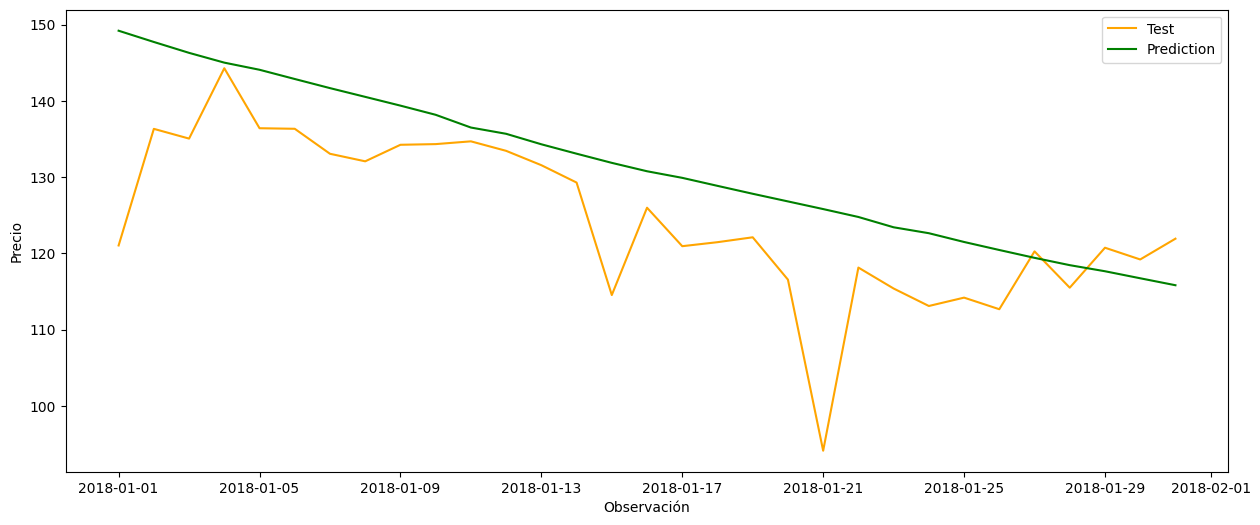

In [77]:
plt.figure(figsize=(15,6))
# plt.plot(df_final["precio_bolsa"], label='Train', color='blue')
plt.plot(test.iloc[:, 0][:31], label='Test', color='orange')
plt.plot(y_pred[:31], label='Prediction', color='green')
# plt.xticks(fechas)
plt.xlabel('Observación')
plt.ylabel('Precio')
plt.legend()
plt.show()